In [2]:
import pandas as pd
import os
import pandas as pd

NEWLINE = '\n'
emailDirPath = "dataset_emails"
def loadEmails(emailDirPath=emailDirPath):
    emails = pd.DataFrame(columns=["email","isSpam"])
    for file in os.listdir(emailDirPath):
        d = os.path.join(emailDirPath, file)
        is_spam = "spam" in d
        if not os.path.isdir(d):continue
        for email in os.listdir(d):
            past_header = False
            f = open(d+"/"+email, encoding="latin-1")
            lines = []
            for line in f:
                if past_header:
                    lines.append(line)
                if line == NEWLINE:
                    past_header = True
            yield NEWLINE.join(lines),int(is_spam)
def loadDF():
    return pd.DataFrame(loadEmails(),columns=["email","isSpam"])
emails = loadDF()
emails.head()


,email,isSpam
0,--------------103227703017104\n\nContent-Type:...,1
1,This is a multi-part message in MIME format.\n...,1
2,<html><head>\n\n<title>Congratulations! You Ge...,1
3,------000000000000000000000\n\nContent-Type: t...,1
4,YOUR SEX DRIVE SHOULD NEVER BE SECOND ON THE L...,1


array([[<AxesSubplot: title={'center': 'isSpam'}>]], dtype=object)

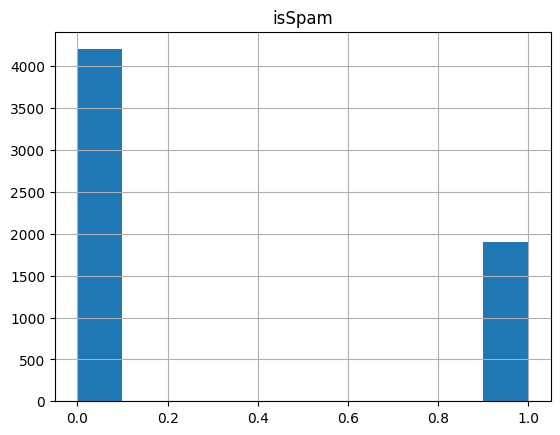

In [6]:
emails.hist()

In [222]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(emails["email"],emails["isSpam"], test_size=0.2,random_state=42)


In [225]:
y_test.shape

(1220,)

In [179]:
X_train

5381    While wandering through Uppsala, Sweden last w...
3921    On Tue, 20 Aug 2002, Matthew Cline wrote:\n\n\...
2107    <html>\n\n<head>\n\n</head>\n\n<body>\n\n\n\n<...
485     =3C!DOCTYPE HTML PUBLIC =22-=2F=2FW3C=2F=2FDTD...
4154    URL: http://diveintomark.org/archives/2002/10/...
                              ...                        
3772    This was just *too* funny.. rotflma.\n\n\n\nht...
5191    Problem with spamtrap\n\nCould not lock /home/...
5226    OK, this site rocks...\n\n\n\nhttp://www.nal.u...
5390    Niall O Broin wrote:\n\n> On Mon, Aug 19, 2002...
860     Give me 5 minutes and I will show you how\n\nt...
Name: email, Length: 4880, dtype: object

In [251]:
URL_REGEX = "(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})"
HEADER_REGEX = "(?s)(.*?)(?:(?:\r*\n){2})"

import nltk
from nltk.stem import PorterStemmer
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer()
STEMMER = PorterStemmer()
possibleWords = dict()
prin = False
import re
import random
def getBinaryWordVector(string, dictionary):
    encoded = np.zeros(len(dictionary))
    words = string.split(' ')
    for word in words:
        index = np.where(dictionary == word)[0]
        if index.size == 1:  # we ignore unknown words
            if binary:
                encoded[index[0]] = 1
            else:
                encoded[index[0]] += 1
    return encoded

def getWords(string, optional_words):
    for word in string["email"].split():
        if word in optional_words: 
            optional_words[word] += 1
        else:
            optional_words[word] = 1
    
def removePunct(string):
    return re.sub("[?.,!-]", '', string)

def convertToLower(string):
    return string.lower()

def replaceNumbers(string):
    return re.sub("\d+", 'NUMBER', string)

def stemWords(string):
    return STEMMER.stem(string)

def replaceURL(string):
    return re.sub(URL_REGEX, 'URL', string)

def removeHeader(string):
    return re.sub(HEADER_REGEX, '', string)

def pipeline(X,train=True,removeheader=True,removepunt=False,lowercase=False,
             replacenumbers=False,stemwords=False,replaceURL=False,numberOfFeatures=100):
    if removeHeader:
        X.map(removeHeader)
    if stemwords:
        X.map(stemWords)
    if replaceURL:
        X.map(replaceURL)
    if removepunt:
        X.map(removePunct)
    if lowercase:
        X.map(convertToLower)
    if replacenumbers:
        X.map(replaceNumbers)

    if train:
        X_res = v.fit_transform(X.values)
    else:
        X_res = v.transform(X.values)
    
    return X_res



In [252]:
type(X_train)

pandas.core.series.Series

In [253]:
type(X_train.values)

numpy.ndarray

In [254]:
X_t_transformed = pipeline(X_train)
type(X_t_transformed[0])
X_t_transformed.shape
y_train.shape

(4880,)

In [255]:
from sklearn.linear_model import LogisticRegression 
log_reg = LogisticRegression()
log_reg.fit(X_t_transformed, y_train)


/Users/tomer/PycharmProjects/pythonProject/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [256]:
score = log_reg.score(X_t_transformed, y_train)
score

0.9995901639344262

In [257]:
X_test.shape

(1220,)

In [258]:
X_test_transformed = pipeline(X_test,train=False)

In [259]:
X_test_transformed.shape

(1220, 109304)

In [260]:
from sklearn.metrics import classification_report

y_pred = log_reg.predict(X_test_transformed)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       826
           1       0.98      0.97      0.98       394

    accuracy                           0.99      1220
   macro avg       0.99      0.98      0.98      1220
weighted avg       0.99      0.99      0.99      1220



In [261]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
sgd_clf.fit(X_t_transformed,y_train)

SGDClassifier()

In [262]:
from sklearn.metrics import classification_report

y_pred = sgd_clf.predict(X_test_transformed)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       826
           1       0.98      0.98      0.98       394

    accuracy                           0.99      1220
   macro avg       0.98      0.98      0.98      1220
weighted avg       0.99      0.99      0.99      1220

